In [1]:
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from compositional_metarl.task import MultiArmedBandit
from compositional_metarl.model import QDNDLSTM as Agent
from compositional_metarl.utils import compute_stats, to_sqnp
from compositional_metarl.model.DND import compute_similarities
from compositional_metarl.model.utils import get_reward, compute_returns, compute_a2c_loss, get_reward_mab, run_agent_inference
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import torch.nn.functional as F
from compositional_metarl.trainers import Trainer, evaluate
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting

sns.set(style='white', context='talk', palette='colorblind')

In [2]:
seed_val = 0 
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed(seed_val)

dtype = torch.float
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
''' task'''

start_arm = 0
end_arm = 7
ctx_dim = 2
n_arms = (end_arm - start_arm) + 1
n_rounds = 20
n_trials = 10
normalize_rewards = True
CUES =  {'linear': torch.tensor([1.0, 0.0]), 'periodic': torch.tensor([0.0, 1.0])} #, 'linperiodic': torch.tensor([1.0, 1.0])} 


In [4]:
''' model'''

inp_dim = 4
inputs = 'action-reward'
dim_output = n_arms
estimate_Qvals = True
dict_len = 1000
kernel = 'cosine' # 'l1' or 'l2'
dnd_policy = 'softmax' # 'softmax' or '1NN'
unique_keys = True
exclude_key = True

In [30]:
def train_evaluate(parameterization):
    agent = Agent(inp_dim, dim_hidden, dim_output, dict_len, inputs=inputs, ctx_dim=ctx_dim, kernel=kernel, dnd_policy=dnd_policy, unique_keys=unique_keys, q_est=estimate_Qvals)
    lr = parameterization.get("lr", 5e-4)
    gamma= parameterization.get("gamma", 0.6)
    trainer = Trainer(agent, task, seed=seed_val, lr=lr, gamma=gamma)
    agent, _, _, _ = trainer.train() 
    
    return evaluate(agent, task)

In [72]:
'''run bayesian optimization'''

task = MultiArmedBandit(cues=CUES, start_arm=start_arm, end_arm=end_arm, ctx_dim=ctx_dim, num_rounds=n_rounds, normalize=normalize_rewards)
best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        {"name": "gamma", "type": "range", "bounds": [0., 1.], "log_scale": False}
    ],
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

[INFO 09-15 11:59:20] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 09-15 11:59:21] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 09-15 11:59:21] ax.service.managed_loop: Running optimization trial 1...


Score improved (nan --> 0.000000).
Epoch 1 / 100| return = 0.51 | loss: val = 0.43, pol = 0.01, entropy = 2.06 | time = 4.61
Score improved (0.000000 --> 0.507998).
Epoch 2 / 100| return = 0.61 | loss: val = 0.41, pol = -0.31, entropy = 1.98 | time = 4.46
Score improved (0.507998 --> 0.609470).
Epoch 3 / 100| return = 0.67 | loss: val = 0.39, pol = -0.44, entropy = 1.97 | time = 4.55
Score improved (0.609470 --> 0.673966).
Epoch 4 / 100| return = 0.62 | loss: val = 0.42, pol = -0.52, entropy = 1.92 | time = 3.80
EarlyStopping counter: 1 out of 20
Epoch 5 / 100| return = 0.69 | loss: val = 0.39, pol = -0.54, entropy = 1.90 | time = 4.11
Score improved (0.673966 --> 0.685620).
Epoch 6 / 100| return = 0.66 | loss: val = 0.41, pol = -0.51, entropy = 1.94 | time = 4.48
EarlyStopping counter: 1 out of 20
Epoch 7 / 100| return = 0.70 | loss: val = 0.40, pol = -0.50, entropy = 1.87 | time = 4.40
Score improved (0.685620 --> 0.700513).
Epoch 8 / 100| return = 0.65 | loss: val = 0.41, pol = -0.5

[INFO 09-15 12:02:50] ax.service.managed_loop: Running optimization trial 2...


Score improved (nan --> 0.000000).
Epoch 1 / 100| return = 0.55 | loss: val = 0.39, pol = -0.19, entropy = 1.94 | time = 4.48
Score improved (0.000000 --> 0.548571).
Epoch 2 / 100| return = 0.58 | loss: val = 0.42, pol = -0.17, entropy = 2.02 | time = 4.31
Score improved (0.548571 --> 0.576510).
Epoch 3 / 100| return = 0.60 | loss: val = 0.39, pol = -0.33, entropy = 2.03 | time = 4.22
Score improved (0.576510 --> 0.596028).
Epoch 4 / 100| return = 0.57 | loss: val = 0.35, pol = -0.24, entropy = 2.01 | time = 4.38
EarlyStopping counter: 1 out of 20
Epoch 5 / 100| return = 0.62 | loss: val = 0.35, pol = -0.09, entropy = 2.00 | time = 4.42
Score improved (0.596028 --> 0.624303).
Epoch 6 / 100| return = 0.58 | loss: val = 0.32, pol = -0.23, entropy = 2.00 | time = 4.50
EarlyStopping counter: 1 out of 20
Epoch 7 / 100| return = 0.60 | loss: val = 0.33, pol = -0.14, entropy = 2.02 | time = 4.38
EarlyStopping counter: 2 out of 20
Epoch 8 / 100| return = 0.56 | loss: val = 0.35, pol = -0.31, e

[INFO 09-15 12:05:52] ax.service.managed_loop: Running optimization trial 3...


Score improved (nan --> 0.000000).
Epoch 1 / 100| return = 0.53 | loss: val = 0.40, pol = -0.17, entropy = 1.98 | time = 4.77
Score improved (0.000000 --> 0.532988).
Epoch 2 / 100| return = 0.60 | loss: val = 0.33, pol = 0.01, entropy = 2.01 | time = 4.26
Score improved (0.532988 --> 0.601550).
Epoch 3 / 100| return = 0.62 | loss: val = 0.32, pol = -0.21, entropy = 2.01 | time = 4.18
Score improved (0.601550 --> 0.616502).
Epoch 4 / 100| return = 0.58 | loss: val = 0.35, pol = -0.26, entropy = 2.02 | time = 4.31
EarlyStopping counter: 1 out of 20
Epoch 5 / 100| return = 0.58 | loss: val = 0.34, pol = -0.11, entropy = 2.01 | time = 4.30
EarlyStopping counter: 2 out of 20
Epoch 6 / 100| return = 0.57 | loss: val = 0.32, pol = -0.05, entropy = 2.03 | time = 4.36
EarlyStopping counter: 3 out of 20
Epoch 7 / 100| return = 0.60 | loss: val = 0.32, pol = -0.42, entropy = 2.01 | time = 4.49
EarlyStopping counter: 4 out of 20
Epoch 8 / 100| return = 0.60 | loss: val = 0.37, pol = -0.19, entropy

[INFO 09-15 12:10:56] ax.service.managed_loop: Running optimization trial 4...


Score improved (nan --> 0.000000).
Epoch 1 / 100| return = 0.61 | loss: val = 1.14, pol = 0.19, entropy = 0.60 | time = 4.18
Score improved (0.000000 --> 0.605759).
Epoch 2 / 100| return = 0.49 | loss: val = 0.43, pol = -0.11, entropy = 1.77 | time = 4.43
EarlyStopping counter: 1 out of 20
Epoch 3 / 100| return = 0.49 | loss: val = 0.42, pol = -0.08, entropy = 2.00 | time = 4.42
EarlyStopping counter: 2 out of 20
Epoch 4 / 100| return = 0.52 | loss: val = 0.41, pol = -0.08, entropy = 2.01 | time = 4.20
EarlyStopping counter: 3 out of 20
Epoch 5 / 100| return = 0.52 | loss: val = 0.42, pol = -0.10, entropy = 2.04 | time = 4.25
EarlyStopping counter: 4 out of 20
Epoch 6 / 100| return = 0.49 | loss: val = 0.41, pol = -0.02, entropy = 2.05 | time = 4.34
EarlyStopping counter: 5 out of 20
Epoch 7 / 100| return = 0.57 | loss: val = 0.42, pol = -0.05, entropy = 2.04 | time = 4.30
EarlyStopping counter: 6 out of 20
Epoch 8 / 100| return = 0.46 | loss: val = 0.41, pol = -0.03, entropy = 2.04 | 

[INFO 09-15 12:12:29] ax.service.managed_loop: Running optimization trial 5...


Score improved (nan --> 0.000000).
Epoch 1 / 100| return = 0.46 | loss: val = 0.41, pol = 0.39, entropy = 2.07 | time = 4.74
Score improved (0.000000 --> 0.463441).
Epoch 2 / 100| return = 0.50 | loss: val = 0.41, pol = 0.40, entropy = 2.07 | time = 4.70
Score improved (0.463441 --> 0.504792).
Epoch 3 / 100| return = 0.50 | loss: val = 0.41, pol = 0.32, entropy = 2.08 | time = 4.48
EarlyStopping counter: 1 out of 20
Epoch 4 / 100| return = 0.51 | loss: val = 0.41, pol = 0.31, entropy = 2.08 | time = 4.43
Score improved (0.504792 --> 0.511043).
Epoch 5 / 100| return = 0.55 | loss: val = 0.41, pol = 0.34, entropy = 2.07 | time = 4.62
Score improved (0.511043 --> 0.552729).
Epoch 6 / 100| return = 0.52 | loss: val = 0.41, pol = 0.31, entropy = 2.07 | time = 4.44
EarlyStopping counter: 1 out of 20
Epoch 7 / 100| return = 0.53 | loss: val = 0.41, pol = 0.28, entropy = 2.07 | time = 4.73
EarlyStopping counter: 2 out of 20
Epoch 8 / 100| return = 0.49 | loss: val = 0.40, pol = 0.31, entropy =

[INFO 09-15 12:15:32] ax.service.managed_loop: Running optimization trial 6...


Score improved (nan --> 0.000000).


/notebooks/src/trainers/trainers.py:86: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/notebooks/src/model/utils.py:110: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



RuntimeError: invalid multinomial distribution (encountering probability entry < 0)

In [ ]:
%debug

In [68]:
trainer = Trainer(agent, task, seed=seed_val, lr=0.04042324285256109, n_trials=n_trials, beta=1., gamma=0.0, normalize_return=True, early_stopping=True)

In [69]:
trainer.train()

Score improved (nan --> 0.000000).


/notebooks/src/trainers/trainers.py:86: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/notebooks/src/model/utils.py:110: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 1 / 100| return = 0.61 | loss: val = 0.40, pol = -0.47, entropy = 1.91 | time = 4.44
Score improved (0.000000 --> 0.606983).
Epoch 2 / 100| return = 0.62 | loss: val = 0.40, pol = -0.45, entropy = 1.92 | time = 4.45
Score improved (0.606983 --> 0.624269).
Epoch 3 / 100| return = 0.67 | loss: val = 0.38, pol = -0.50, entropy = 1.92 | time = 4.46
Score improved (0.624269 --> 0.665312).
Epoch 4 / 100| return = 0.64 | loss: val = 0.40, pol = -0.50, entropy = 1.92 | time = 4.29
EarlyStopping counter: 1 out of 20
Epoch 5 / 100| return = 0.65 | loss: val = 0.40, pol = -0.69, entropy = 1.86 | time = 4.63
EarlyStopping counter: 2 out of 20
Epoch 6 / 100| return = 0.66 | loss: val = 0.40, pol = -0.53, entropy = 1.93 | time = 4.29
EarlyStopping counter: 3 out of 20
Epoch 7 / 100| return = 0.66 | loss: val = 0.39, pol = -0.48, entropy = 1.93 | time = 4.48
EarlyStopping counter: 4 out of 20
Epoch 8 / 100| return = 0.64 | loss: val = 0.41, pol = -0.58, entropy = 1.90 | time = 4.13
EarlyStoppin

(QDNDLSTM(
   (i2h): Linear(in_features=4, out_features=320, bias=True)
   (h2h): Linear(in_features=64, out_features=320, bias=True)
   (a2c): A2C(
     (ih): Linear(in_features=64, out_features=64, bias=True)
     (actor): Linear(in_features=64, out_features=8, bias=True)
     (critic): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 array([-793.96814728, -788.40180206, -815.083395  , -804.48659706,
        -858.81056976, -825.11432838, -807.81925774, -829.30327988,
        -842.63593102, -827.10493565, -806.55787659, -811.88845062,
        -801.55737495, -815.06477356, -844.14279175, -820.81296349,
        -830.50608444, -824.38023949, -784.02799416, -817.92995834,
        -817.5187149 , -802.81866646, -828.91145897, -781.86576653,
        -818.45567513, -835.49422073, -820.42216301, -842.72343063,
        -825.63899422]),
 array([0.60698304, 0.62426891, 0.6653115 , 0.64456321, 0.65419962,
        0.65512973, 0.65999876, 0.63995957, 0.67289702, 0.61404091,
        0.6388

In [71]:
best_parameters

{'lr': 0.04042324285256109, 'gamma': 0.0}

In [64]:
means, covariances = values
means, covariances

({'accuracy': 0.9999999506759155},
 {'accuracy': {'accuracy': 2.6315786918006343e-09}})

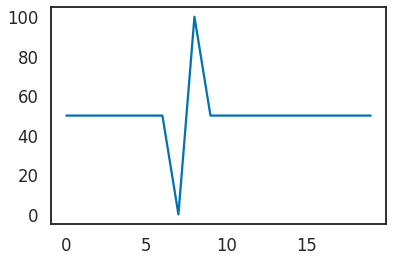

In [65]:
# optimization runs, so we wrap out best objectives array in another array.
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])
plt.plot(best_objectives[0])